### Inspecting Github Data

Before startind there should be a github user data file in the folder of this notebook, see the configurations in the cell below. The github users data file is a pickle file with a ready netoworkx graph.

**We begin our study by reading the pickle file from filesystem to get a graph to work with:**

In [1]:
GITHUB_USERS_FILE = 'github_users.p' # Pickle file with users

In [2]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import nxviz as nv

In [3]:
with open(GITHUB_USERS_FILE, 'rb') as f:
    G = pickle.load(f)

In [4]:
G

### Basic graph inspection

First of all, we can see that this is a graph object (not di or multigraph, for example). Next we move onto some basic inspecting the structure of this network

In [5]:
print(f'Number of nodes : {len(G.nodes())}')
print(f'Number of edges : {len(G.edges())}')

Number of nodes : 56519
Number of edges : 72900


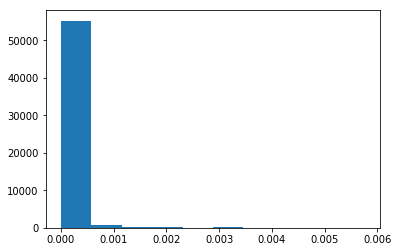

In [6]:
# Make a histogram of the degree centrality distribution of the graph
plt.hist(list(nx.degree_centrality(G).values()))
plt.show()

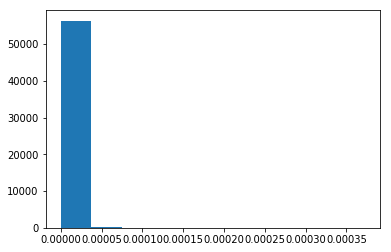

In [7]:
# Make a histogram of the betweenness centrality distribution of the graph
myk = int(len(G.nodes)/100)
plt.hist(list(nx.betweenness_centrality(G, k=myk).values()))
plt.show()

In [8]:
# Inspecting our connected components subgraph
subgraphs = nx.connected_component_subgraphs(G)
largest_ccs = sorted(subgraphs, key=lambda x: len(x))[-1]
print(f'found number of subgraphs {subgraphs} and the larges subgraph is {type(largest_ccs)}')
print(f'largest ccs num nodes : {len(largest_ccs.nodes())}, num edges : {len(largest_ccs.edges)}')


found number of subgraphs <generator object connected_component_subgraphs at 0x7fb2987c9a20> and the larges subgraph is <class 'networkx.classes.graph.Graph'>
largest ccs num nodes : 5188, num edges : 72351


In [9]:
W = largest_ccs.subgraph(list(largest_ccs.nodes())[::20])
print(f'Created subgraph from largest_ccs (5% size) for comp efficiency : {len(W.nodes())}, num edges : {len(W.edges)}')

Created subgraph from largest_ccs (5% size) for comp efficiency : 260, num edges : 201


### Some concepts

Two interesting metrics on understanding graphs are degree centrality and betweenness centrality of nodes. These concepts are good to have a grasp on:
- Degree centrality:
  * The number of nodes a certain node has as neighbors
  * Can tell us how connected the node is in the network, how many neighbors it has basically
  * `nx.degree_centrality(G)`
- Betweenness centrality
  * How many shortest paths goes through the node
  * Tells us how much the given node acts as a hub in the network
  * `nx.betweenness_centrality(G)`
- Connected components subgraph
  * Subgraphs which are not connected to one another in the graph
  * `nx.connected_components_subgraph(G)`
  
**Next we move onto visualizing our network in some ways with nxviz**

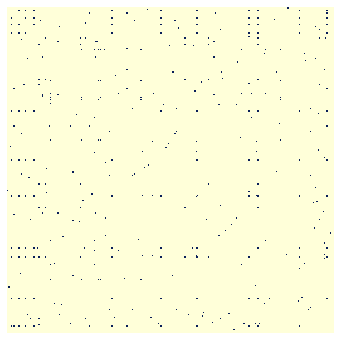

In [10]:
## First the matrixplot
h = nv.MatrixPlot(graph=W, node_grouping='bipartite') # group by some data key
h.draw()
plt.show()

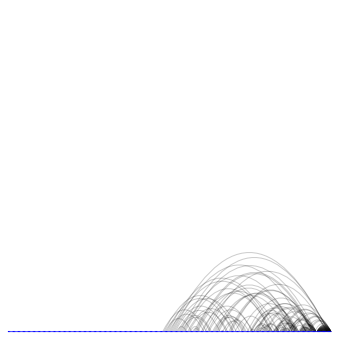

In [11]:
## Arcplots
# First lets add the degrees of the node as a metadata to the nodes
for n, d in W.nodes(data=True):
    largest_ccs.node[n]['degree'] = nx.degree(W, n)
# Next we do the arcploy and use the degree as node order
a = nv.ArcPlot(graph=W, node_order='degree')
a.draw()
plt.show()

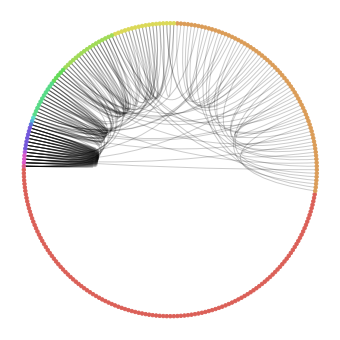

In [12]:
## Circos plots
# First lets add the degrees of the node as a metadata to the nodes
for n, d in W.nodes(data=True):
    W.node[n]['degree'] = nx.degree(W, n)

c = nv.CircosPlot(graph=W, node_order='degree', node_grouping='degree', node_color='degree')
c.draw()
plt.show()

### Analyzing Cliques

Some definitions first:
- A clique is a group of nodes that are fully connected
- The simplest clique is an edge, and the simplex complex clique is a triangle
- A maximal clique is a clique which cannot be extended

In [18]:
# We can get all the cliques
cliques = nx.find_cliques(W)
print(f'There are {len(list(cliques))} cliques in the graph')

There are 191 cliques in the graph


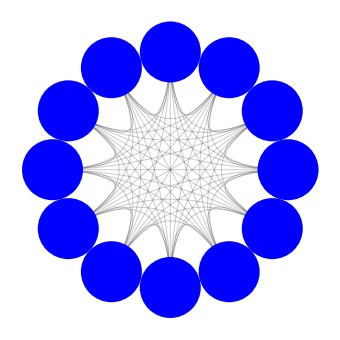

In [21]:
## We can pull out the largest clique
largest_clique = sorted(nx.find_cliques(W), key=lambda x:len(x))[-1]

# Create the subgraph of the largest_clique: G_lc
G_lc = W.subgraph(largest_clique)

# Create the CircosPlot object: c
c = nv.CircosPlot(G_lc)

# Draw the CircosPlot to the screen
c.draw()
plt.show()

### Applicability

Lets do something useful with what we've learned so far:
- Finding important users (by high degree centrality)
- Finding communities (by maximum cliques)
- Building a recommendations system (By using open triangles)

#### On open triangles

Open triangles occur when one node is connected to two other nodes which are not connected to one another. A viable recommendation system may then be put in place by recommending those nodes to close with one another

In [29]:
### PROLIFIC CONTRIBUTERS ###

# Compute the degree centralities of G: deg_cent
deg_cent = nx.degree_centrality(W)

# Compute the maximum degree centrality: max_dc
max_dc = max(deg_cent.values())

# Find the user(s) that have collaborated the most: prolific_collaborators
prolific_collaborators = [n for n, dc in deg_cent.items() if dc == max_dc]

# Print the most prolific collaborator(s)
print(prolific_collaborators)

['u4296']


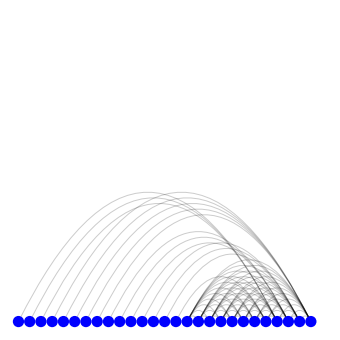

In [30]:
### COMMUNITIES ###

# Identify the largest maximal clique: largest_max_clique
largest_max_clique = set(sorted(nx.find_cliques(W), key=lambda x: len(x))[-1])

# Create a subgraph from the largest_max_clique: G_lmc
G_lmc = W.subgraph(largest_max_clique).copy()  

# Go out 1 degree of separation
for node in list(G_lmc.nodes()):
    G_lmc.add_nodes_from(W.neighbors(node))
    G_lmc.add_edges_from(zip([node]*len(list(W.neighbors(node))), W.neighbors(node)))

# Record each node's degree centrality score
for n in G_lmc.nodes():
    G_lmc.node[n]['degree centrality'] = nx.degree_centrality(G_lmc)[n]
    

# Create the ArcPlot object: a
a = nv.ArcPlot(G_lmc, node_order='degree centrality')

# Draw the ArcPlot to the screen
a.draw()
plt.show()

In [31]:
### A simple recommendation system ###

# Import necessary modules
from itertools import combinations
from collections import defaultdict

# Initialize the defaultdict: recommended
recommended = defaultdict(int)

# Iterate over all the nodes in G
for n, d in G.nodes(data=True):

    # Iterate over all possible triangle relationship combinations
    for n1, n2 in combinations(G.neighbors(n), 2):

        # Check whether n1 and n2 do not have an edge
        if not G.has_edge(n1, n2):

            # Increment recommended
            recommended[(n1, n2)] += 1

# Identify the top 10 pairs of users
all_counts = sorted(recommended.values())
top10_pairs = [pair for pair, count in recommended.items() if count > all_counts[-10]]
print(top10_pairs)

[('u264', 'u655'), ('u627', 'u3082'), ('u363', 'u1208'), ('u89', 'u325'), ('u741', 'u935'), ('u268', 'u741')]
